In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mesa_tricks.io import read_gyre

In [2]:
FILE = '/data/MESA/ε Isochrones/tracks_0.00/LOGS_1.00/profile11.data.GYRE'

info, gyre = read_gyre(FILE)

from mesa_tricks.ray import RayProblem

p = RayProblem(info, gyre)

from astropy import units as u, constants as c
T = gyre['T'].iloc[-1]
ω0 = (2 * np.pi * 3090 * u.uHz).cgs.value * info['M'] / c.M_sun.cgs.value / (info['R'] / c.R_sun.cgs.value)**2 / np.sqrt(T / 5777)

/home/joel/Git/mesa-tricks/mesa_tricks/ray/__init__.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return cs2_(r) * L2 / r**2 * (N2_(r) / ω**2 - 1) + ω**2 - ωc2_(r)
/home/joel/Git/mesa-tricks/mesa_tricks/ray/__init__.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return cs2_(r) * L2 / r**2 * (N2_(r) / ω**2 - 1) + ω**2 - ωc2_(r)
/home/joel/Git/mesa-tricks/mesa_tricks/ray/__init__.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return cs2_(r) * L2 / r**2 * (N2_(r) / ω**2 - 1) + ω**2 - ωc2_(r)
/home/joel/Git/mesa-tricks/mesa_tricks/ray/__init__.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return cs2_(r) * L2 / r**2 * (N2_(r) / ω**2 - 1) + ω**2 - ωc2_(r)


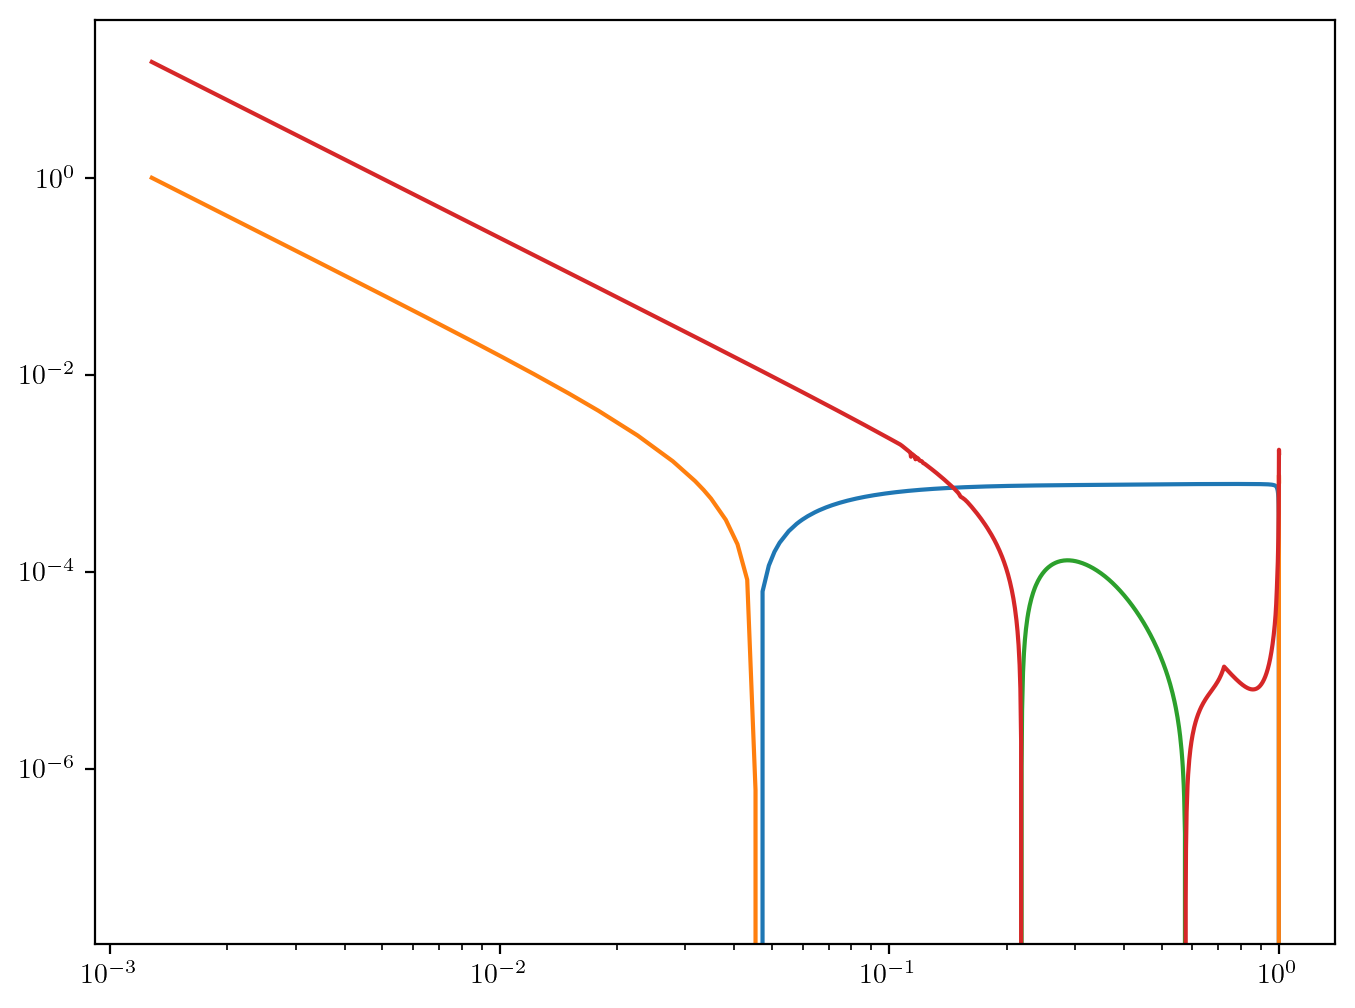

In [3]:
r = gyre['r'].values
R = float(info['R'])
plt.plot(r/R, p.X(1, ω0, r))
plt.plot(r/R, -p.X(1, ω0, r))
plt.plot(r/R, p.X(5, ω0 / 30 * 1.9, r))
plt.plot(r/R, -p.X(5, ω0 / 30 * 1.9, r))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

In [4]:
# In addition to l=1 and l=60 modes at νmax,
# I show the l=5 g-mode at ν ~ 190 μHz that is also shown in Gough (1993).
rays = [p.solve_ray(l, ω, x0, x1, branch=pm, t=t, f=1/ω**2, max_step=t/300)
        for i, (l, ω, x0, x1, pm, t)
        in enumerate([[5, ω0 / 30 * 1.9, .2, .3, -1, 120], [1, ω0, .01, .1, 1, 340], [60, ω0, .7, .8, 1, 900]])]

# We will show the inner/outer turning points of the g-mode, and the inner turning point of the l=1 mode.
rs = [p.solve_r0(l, ω, x0, x1)
      for l, ω, x0, x1
      in [[5, ω0 / 30 * 1.9, .01, .3], [5, ω0 / 30 * 1.9, .3, .7], [1, ω0, .01, .9]]]

In [5]:
from scipy.interpolate import UnivariateSpline
from mesa_tricks.integrals.ε import tt
from mesa_tricks.integrals.ε_g import ff

t = tt(gyre)
t_ = UnivariateSpline(gyre['r'] / R, t / t[-1], s=0)
tinv = UnivariateSpline(t / t[-1], gyre['r'], s=0)

# f = ff(gyre)
i0, i1 = -1, -1
for i in range(len(gyre)):
    if i0 < 0 and gyre['N2'][i] > 0:
        i0 = i
    elif i0 > 0 and gyre['N2'][i] < 0:
        i1 = i
        break

g = gyre[i0:i1]
f = ff(g)
finv = UnivariateSpline(f[~np.isnan(f)] / np.nanmax(f), g['r'][~np.isnan(f)], s=0)
f[np.isnan(f)] = np.nanmax(f)
f__ = UnivariateSpline(g['r']/ R, f / np.nanmax(f), s=0)
f_ = lambda x: np.where(x < np.min(g['r'] / R), 0, np.where(x > np.max(g['r'] / R), 1, f__(x)))

# sqrt = np.sqrt
# sqr = lambda x: np.power(x, 2) * R

sqrt = lambda x: x
sqr = lambda x: x * R

scales = [t_, sqrt, f_]
scales_inv = [tinv, sqr, finv]

θ0 = np.linspace(0, 2*np.pi)
r0 = np.linspace(0, 1, 200)
r, θ = np.meshgrid(r0, θ0[:-1])
maps = [np.nan_to_num(p.X(1, ω0, scl(r)) / p.cs2_(scl(r))) for scl in scales_inv]

N = 500

def make_plots(n):

    ax = []

    ax.append(plt.subplot(131, polar=True))
    ax.append(plt.subplot(132, polar=True))
    ax.append(plt.subplot(133, polar=True))

    for a in ax:
        plt.sca(a)
        a.set_rlim(0, 1)
        plt.axis('off')

    r, θ = np.meshgrid(r0, θ0[:-1])
    for scl, a, z in zip(scales_inv, ax, maps):
        plt.sca(a)
        plt.pcolormesh(θ, r, np.sign(z) / np.abs(np.log10(np.abs(z))), cmap='RdYlBu', shading='auto', vmin=-1e-1, vmax=1e-1, alpha=.9)


    for r in rs:
        for scl, a in zip([t_, sqrt, f_], ax):
            plt.sca(a)
            plt.plot(θ0, scl(r / R) * np.ones_like(θ0), c='r', ls='dotted', lw=.8)

    s = slice(None, n)

    for i, res in enumerate(rays):
        r = res['y'][0]
        θ = res['y'][-1]
        t = res['t']
        r_ = UnivariateSpline(t, r, s=0, k=3)
        θ_ = UnivariateSpline(t, θ, s=0, k=3)
        
        t = np.linspace(np.min(t), np.max(t), N)[s]
        r = r_(t)
        θ = θ_(t)
        
        for scl, a in zip(scales, ax):
            plt.sca(a)
            plt.plot(θ, scl(r), c=f"C{i}")
            plt.arrow(θ[-1], scl(r)[-1], np.diff(θ)[-1], np.diff(scl(r))[-1],
                      length_includes_head=True, shape='full', head_width=.06, color=f"C{i}")

    opts = {'pad': 0}
    ax[0].set_title(r'$t/T$' , **opts)
    ax[1].set_title(r'$r/R$' , **opts)
    ax[2].set_title(r'$f_0/F_0$', **opts)

/home/joel/Git/mesa-tricks/mesa_tricks/ray/__init__.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return cs2_(r) * L2 / r**2 * (N2_(r) / ω**2 - 1) + ω**2 - ωc2_(r)


In [6]:
make_plots(None)
plt.tight_layout()
plt.gcf().set_size_inches(12, 4)
plt.savefig(f"rays.png", dpi=300, transparent=True, bbox_inches='tight')
plt.close('all')

In [7]:
from tqdm.auto import trange
for i in trange(2, N):
    make_plots(i)
    plt.tight_layout()
    plt.gcf().set_size_inches(12, 4)
    plt.savefig(f"anim/{i-2:03d}.png", dpi=300, transparent=True, bbox_inches='tight')
#     plt.show()
    plt.close('all')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# For verification purposes I've implemented the same thing using the pure p-mode description

def dWdk(l, r, k_r, pm=1): # dr/dt = dW/dk
    L2 = l * (l + 1)
    kh2 = L2 / r**2
    c2k2 = cs2_(r) * (k_r**2 + kh2)
    Wp = c2k2 + ωc2_(r) # pure-p component
    return 2 * cs2_(r) * k_r

def dWdr(l, r, k_r, pm=1):
    L2 = l * (l + 1)
    kh2 = L2 / r**2
    c2k2 = cs2_(r) * (k_r**2 + kh2)
    Wp = c2k2 + ωc2_(r) # pure-p component
    dWpdr = cs2_(r, 1) * (k_r**2 + kh2) - 2 * cs2_(r) * L2 / r**3 + ωc2_(r, 1)
    
    return dWpdr

def dWdkθ(l, r, k_r):
    L2 = l * (l + 1)
    kh2 = L2 / r**2
    c2k2 = cs2_(r) * (k_r**2 + kh2)
    Wp = c2k2 + ωc2_(r) # pure-p component
    
    return 2 * cs2_(r) * np.sqrt(kh2) / r
    

# from scipy.integrate import solve_ivp

# def fun(t, y):
#     l = 15
#     r = y[0] * R
#     k_r = y[1] / R
#     θ = y[2]
#     f = 1e4
#     branch = 1
#     return np.array([dWdk(l, r, k_r, pm=branch) / R,
#                      -dWdr(l, r, k_r, pm=branch) * R,
#                      dWdkθ(l, r, k_r, pm=branch)]) * f

# r0 = solve_r0(15, ω0, .01, .9)

# res = solve_ivp(fun, [0,100], [r0 / R, 0, 0], method='Radau')